# Import Dependencies and Define Functions

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Import Dependencies and Define Functions

%matplotlib notebook

#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import os
from tkinter import Tk
from tkinter.filedialog import askdirectory
from iapws import IAPWS97 as steam_prop
import matplotlib.animation as animation
from matplotlib.widgets import Slider


#Define critical pressure ratio
alpha = 0.55

#Define a function that calculates the density for a given pressure and temperature
def calc_rho(p, t):
    
    #convert psia to MPA
    pressure = p*0.00689476
    
    #convert farenheit to Kelvin
    temp = (t - 32)*5/9 + 273.15
    
    #get the density 
    r = steam_prop(P=pressure, T=temp).v
    rho = steam_prop(P=pressure, T=temp).rho
    
    #convert density from kg/M^3 to lb/ft^3
    rho = rho*0.062428
    
    return rho

#piecewise linear fit
def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])

    
#Function for getting user input on curve fitting
def user_plot_fit(x0_start, x1_start, title, xdata, ydata, xlabel, ylabel, xunits, yunits):
    
    #re-initialize global x0 - assumption for first breakpoint
    #re-initialize global x1 - assumption for second breakpoint
    global x0 
    global x1
    x0 = x0_start
    x1 = x1_start

    #optimize piecewise fit with user-defined breakpoints
    p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)

    #Define range for governor demand model
    model_x = np.linspace(-1, 100, 100)

    # Create figure and axis objects
    fig, ax = plt.subplots()

    #add plot labels
    plt.title(f"Use Sliders to Adjust Curve Fit!\n\n{title}")
    plt.ylabel(f"{ylabel}\n({yunits})")
    plt.xlabel(f"{xlabel}\n({xunits})")

    #plot historical/design data
    data, = plt.plot(xdata, ydata, 'o')

    #plot piecewise curve fit
    fit, = plt.plot(model_x, piecewise_linear(model_x, *p))

    #left, bottom, width, height
    ax_break1 = plt.axes([0.25, 0.05, 0.50, 0.02])
    ax_break2 = plt.axes([0.25, 0.02, 0.50, 0.02])

    #Create slider animations for the breakpoints
    slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=x0_start)
    slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=x1_start)
    
    def update(val):
        global x0
        global x1
        x0 = slider1.val
        x1 = slider2.val
        # update curve
        p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)
        fit.set_ydata(piecewise_linear(model_x, *p))
        # redraw canvas while idle
        fig.canvas.draw_idle()

    # call update function on slider value change
    slider1.on_changed(update)
    slider2.on_changed(update)

    #show plot
    plt.tight_layout(pad=4)
    plt.show()

    #Save results to DataFrame
    dictionary = {
        xlabel : ax.get_children()[1]._x,
        ylabel : ax.get_children()[1]._y
        }
     
    model_df = pd.DataFrame(dictionary)
    model_df.to_csv(f"projects/{project}/{ylabel}_model.csv")
    
    return model_df

#define a function that gets the flow regime for a given jratio nd pratio
def get_regime(jratio, pratio):
    # return 1 if "Neither Choked"
    # return 2 if "Governor Choked"
    # return 3 if "Nozzle Choked"
    # return 4 if "Both Choked"
    
    global alpha
    
    #Define the intersection of the curves
    triple_point = alpha + (alpha - 1) *0.55**2/alpha
    
    #if jratio is to the right of the triple point, test for neither choked or nozzle choked
    if jratio > 0.55:
        
        #define the limit below which the nozzle is choked
        limit = alpha*jratio*(jratio-(-4*alpha+jratio**2+4)**0.5)/(2*(alpha-1))
        
        #test if the pratio is in "neither choked" or "nozzle choked" regime
        if pratio > limit:
            return 1
        else:
            return 3
    
    #if jratio is to the left of the triple point, test for neither choked, governor choked, or both choked
    else:
        
        #define the limit below which both are choked
        limit = triple_point/alpha*jratio
        
        #if the pratio is below the limit, the flow is "both choked"
        if pratio < limit:
            return 4
        
        #if not, define the limit below which the governover is choked
        else:
            limit = alpha + (alpha-1)*jratio**2/alpha
            
            #if the pratio is below the limit, the flow is "governor choked"
            if pratio < limit:
                return 2
            else:
                return 1

#Define a function that calculates the Bowl Pressure Ratio from flow regime, jratio, and pratio
#case 1 neither choked
# pbr = 1/2(-jr^2 + pxr + sqrt(4*jr^2 + jr^4 - 2*jr^2*pxr + pxr^2))
# flow = jr*sqrt(rho_in*(1-pbr))

#case 2 governor choked
#pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))
# flow = jr*sqrt(rho_in*(1-alpha)) 

#case 3 nozzle choked
#pbr = 1/2( - jr^2/(1-alpha) - jrsqrt(4+jr^2-4*alpha)/(-1+alpha))
#flow = jr*sqrt(rho_in*(1-pbr))

def calc_pbr(regime, j_ratio, p_ratio):
        
        #Use notebook alpha
        global alpha
        
        if regime == 1:
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2 + p_ratio + (4*j_ratio**2 + j_ratio**4 - 2*p_ratio*j_ratio**2 + p_ratio**2)**0.5)

        elif regime == 2:
            #pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))

            #Calculate bowl pressure
            pbr = 0.5*(p_ratio + (4*j_ratio**2 + p_ratio**2 - 4*j_ratio**2*alpha)**0.5)

        elif regime == 3:
            #pbr = 1/2( - jr^2/(1-alpha) - jrsqrt(4+jr^2-4*alpha)/(-1+alpha))
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2/(1-alpha) -j_ratio*(4+j_ratio**2 - 4*alpha)/(alpha-1))

        elif regime == 4:
            
            #pbr =??????

            #Calculate bowl pressure
            pbr = 0.5
        
        return pbr

    
#Define a function that calculates the flow in KPPH from flow regime, inlet pressure, governor j, and pb
def calc_flow(regime, pi, pb, jgv, r):

        #Use notebook alpha
        global alpha
        
        if (regime == 1):

            flow = 3.6*jgv*(r*(pi-pb))**0.5
        
        elif regime ==3:
            
            flow = 3.6*jgv*(r*(pi-pb))**0.5

        elif regime == 2:

            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        elif regime ==4:
            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        return flow


In [2]:
# # Open a Project

#Ask if user would like to open a project
open_flag = input("Would you like to return to an existing project?(y/n)")

#If user requests to open project, request project name
if open_flag == "y":
    try:
        path = askdirectory(title="Select Project Folder")
    except:
        print("File open failed.")

# In[4]:
    #get project name
    list_path = path.split(sep="/")
    open_project = list_path[-1]
    project = open_project

    #Load available dataframes
    try:
        single_dmd_df = pd.read_csv(f"projects/{open_project}/single_dmd_curve.csv")
    except:
        print("Couldn't load 'single_dmd_curve.csv' from project")
        
    try:
        gv_demand_df = pd.read_csv(f"projects/{open_project}/sequential_dmd_curve.csv")
        #Use integer division to get number of governor valves
        gov_no = len(gv_demand_df.columns)//2
    except:
        print("Couldn't load 'sequential_dmd_curve.csv' from project")
        
    try:
        design_df = pd.read_csv(f"projects/{open_project}/design_data.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_flow_model_df = pd.read_csv(f"projects/{open_project}/steam_flow_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        tp_model_df = pd.read_csv(f"projects/{open_project}/tp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_temp_model_df = pd.read_csv(f"projects/{open_project}/steam_temp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        first_stage_model_df = pd.read_csv(f"projects/{open_project}/first_stage_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
# # Define a New Project

else:
    #Get a project name from the user
    project = input("What would you like to call this project?")

    #Create a Directory for the project
    try:
        os.mkdir("projects")
    except:
        print("Couldn't make new 'projects' directory")
    try:
        os.mkdir(f"projects/{project}")
    except:
        print(f"Couldn't make new '{project}' directory")


    # # Define Single Mode Governor Demand to Valve Position Curve

    #Import Governor Demand to Single Valve Demand curve
    user_x = input("Enter the x values for Single Valve Mode")
    user_y = input("Enter the y values for Single Valve Mode")
    list_x = user_x.split()
    list_y = user_y.split()
        
    #convert list of strings to list of floats
    x_axis = [float(i) for i in list_x]
    y_axis = [float(i) for i in list_y]
        
    #Tell user what was entered
    print(f"You entered {len(x_axis)} x values and {len(y_axis)} y values")
    data = {"Governor Demand" : x_axis, "Valve Position Demand" : y_axis}
    single_dmd_df = pd.DataFrame(data)

    #Save Dataframe to csv
    single_dmd_df.to_csv(f"projects/{project}/single_dmd_curve.csv")

    #plot the governor demand single valve curve
    plt.plot(single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"], "o-")
    plt.title("Single Valve Mode\nValve Position Demand vs Governor Demand\n")
    plt.ylabel("Valve Position Demand (%)")
    plt.xlabel("\nGovernor Valve Demand (%)")
    plt.tight_layout()

    #save the figure to the project directory
    plt.savefig(f"projects/{project}/single_dmd_curve.png")


    # # Define Sequential Mode Governor Demand to Valve Positions Curves

    #Get number of governor valves from the user
    gov_no = int(input("How many governor valves are there?"))

    #Create a list of column titles for Pandas dataframe
    titles = []
    for i in range(gov_no):
        titles.append("GV"+str(i+1)+" x")
        titles.append("GV"+str(i+1)+" y")
    print(titles)

    #For each governor valve enter the
    gv_demand_curves = []
    for i in range(gov_no):
        user_x = input(f"Copy the x values for GV #{i+1} ")
        user_y = input(f"Copy the y values for GV #{i+1} ")
        list_x = user_x.split()
        list_y = user_y.split()
        
        #convert list of strings to list of floats
        list_x = [float(i) for i in list_x]
        list_y = [float(i) for i in list_y]
        
        #Append lists to the master list
        gv_demand_curves.append(list_x)
        gv_demand_curves.append(list_y)

    #Define a dictionary of the governor valve demand curves
    dictionary = {}
    for i in range(2*gov_no):
        dictionary.update({titles[i] : gv_demand_curves[i]})

    #Use dictionary to create a pandas dataframe
    gv_demand_df = pd.DataFrame(dictionary)
    gv_demand_df

    #Save Dataframe to csv
    gv_demand_df.to_csv(f"projects/{project}/sequential_dmd_curve.csv")

    #Create a plot of all the governor demand curves
    for i in range(gov_no):
        plt.plot(gv_demand_df.iloc[:,i*2], gv_demand_df.iloc[:,i*2+1], 'o-')

    #Create Labels
    legend_list = [f"GV{i+1}" for i in range(gov_no)]
    plt.legend(legend_list)

    #Add labels
    plt.title("Sequential Valve Mode\nValve Position Demand vs Governor Demand\n")
    plt.ylabel("Valve Position Demand (%)")
    plt.xlabel("\nGovernor Valve Demand (%)")

    #save figure
    plt.savefig(f"projects/{project}/sequential_dmd_curve.png")


    # # Define the Design Performance

    #Define the desired performance

    #get a list from the user comparing governor demand and measured steam flow
    input_dmd = input("input governor demand historical data")
    input_steam_flow = input("input steam flow historical data")
    input_throttle_p = input("input throttle pressure historical data")
    input_steam_temp = input("input main steam temperature historical data")
    input_1st_p = input("input first stage pressure historical data")
    input_mwg = input("input Generator MW historical data")

    #split input by spaces
    list_dmd = input_dmd.split()
    list_steam_flow = input_steam_flow.split()
    list_throttle_p = input_throttle_p.split()
    list_steam_temp = input_steam_temp.split()
    list_1st_p = input_1st_p.split()
    list_mwg = input_mwg.split()
        
    #convert list of strings to list of floats
    list_dmd = [float(i) for i in list_dmd]
    list_steam_flow = [float(i) for i in list_steam_flow]
    list_throttle_p = [float(i) for i in list_throttle_p]
    list_steam_temp = [float(i) for i in list_steam_temp]
    list_1st_p = [float(i) for i in list_1st_p]
    list_mwg = [float(i) for i in list_mwg]

    #Define a dictionary of the governor valve demand curves
    dictionary = {
        "Governor Demand (Design)" : list_dmd,
        "Steam Flow (Design)" : list_steam_flow,
        "Throttle Pressure" : list_throttle_p,
        "Main Steam Temperature" : list_steam_temp,
        "First Stage Pressure (Design)" : list_1st_p,
        "Generator MWG" : list_mwg
    }

    #Use dictionary to create a pandas dataframe
    design_df = pd.DataFrame(dictionary)

    #Save dataframe to csv
    design_df.to_csv(f"projects/{project}/design_data.csv")
    
    #Define Steam Flow Model
    steam_flow_model_df = user_plot_fit(
        33,
        66,
        "Steam Flow vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Steam Flow (Design)"].tolist(),
        "Governor Demand",
        "Steam Flow",
        "%",
        "KPPH"
    )

    steam_flow_model_df.to_csv(f"projects/{project}/steam_flow_model.csv")

    #Define Throttle Pressure Model
    tp_model_df = user_plot_fit(
        33,
        66,
        "Throttle Pressure vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Throttle Pressure"].tolist(),
        "Governor Demand",
        "Throttle Pressure",
        "%",
        "psia"
    )

    tp_model_df.to_csv(f"projects/{project}/tp_model.csv")

    #Define Main Steam Temperature Model
    steam_temp_model_df = user_plot_fit(
        33,
        66,
        "Steam Temperature vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Main Steam Temperature"].tolist(),
        "Governor Demand",
        "Steam Temp",
        "%",
        "F"
    )

    steam_temp_model_df.to_csv(f"projects/{project}/steam_temp_model.csv")


    #Define First Stage Pressure Model
    first_stage_model_df = user_plot_fit(
        33,
        66,
        "First Stage Pressure vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["First Stage Pressure (Design)"].tolist(),
        "Governor Demand",
        "First Stage Pressure",
        "%",
        "psia"
    )

    first_stage_model_df.to_csv(f"projects/{project}/first_stage_model.csv")

Would you like to return to an existing project?(y/n)y


# Create Model Definitions Relating Governor Demand and Flow / Thermo 

     GV1 lift  GV1 area  GV2 lift  GV2 area  GV3 lift  GV3 area  GV4 lift  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.5       0.5       0.5       0.5       0.5       0.5       0.5   
2         1.0       1.0       1.0       1.0       1.0       1.0       1.0   
3         1.5       1.5       1.5       1.5       1.5       1.5       1.5   
4         2.0       2.0       2.0       2.0       2.0       2.0       2.0   
5         2.5       2.5       2.5       2.5       2.5       2.5       2.5   
6         3.0       3.0       3.0       3.0       3.0       3.0       3.0   
7         3.5       3.5       3.5       3.5       3.5       3.5       3.5   
8         4.0       4.0       4.0       4.0       4.0       4.0       4.0   
9         4.5       4.5       4.5       4.5       4.5       4.5       4.5   
10        5.0       5.0       5.0       5.0       5.0       5.0       5.0   
11        5.5       5.5       5.5       5.5       5.5       5.5       5.5   

<IPython.core.display.Javascript object>


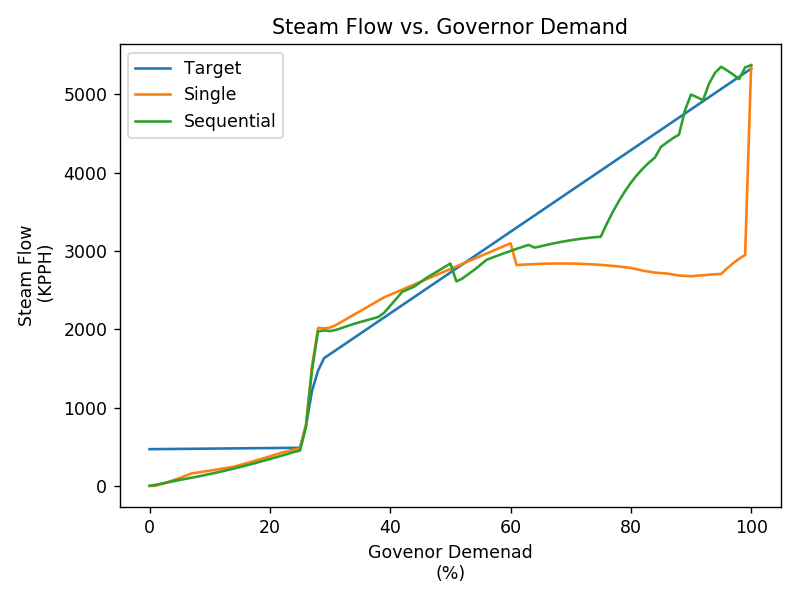

In [3]:
# ## Define Trim Curves

#Start with linear trim curves
trim_list = []

#Define the resolution
res = 200
top = 100 + 100/res
step = 100/res

for x in range(gov_no):
    trim_list.append(np.arange(0,top,step))
    trim_list.append(np.arange(0,top,step))

#Create a list of column titles for Pandas dataframe
titles = []
for i in range(gov_no):
    titles.append("GV"+str(i+1)+" lift")
    titles.append("GV"+str(i+1)+" area")
    
#Define a dictionary of the governor trim curves
dictionary = {}
for i in range(2*gov_no):
    dictionary.update({titles[i] : trim_list[i]})

#Use dictionary to create a pandas dataframe
gv_trim_df = pd.DataFrame(dictionary)

#Save Dataframe to csv
gv_trim_df.to_csv(f"projects/{project}/gov_trim_curve.csv")
print(gv_trim_df)


# ## Define the tables translating Governor Demand to Flow Coefficient 


# # Compare Actual to Desired Performance
# 
# For Governor Demands 0 to 100 in Single Valve Mode and Sequential Mode calculate:
# 
# 1) The pressure ratio for each governor valve
# 
# 2) The j for each governor valve
# 
# 3) the jratio for each governor valve
# 
# 4) the flow regime for each governor valve
# 
# 5) the bowl pressure for each governor valve
# 
# 6) the flow for each governor valve
# 
# 7) the difference from the desired performance

#---------------------------------------------
#---------------------------------------------
#
# Calculate the test values using the defined models
#
#---------------------------------------------
#---------------------------------------------

# Define the governor demands to test against
top = 101
step = 1
gov_dmd = np.arange(0,top, step)

#Define the throttle pressure
tp = np.interp(gov_dmd, tp_model_df["Governor Demand"], tp_model_df["Throttle Pressure"])

#Define the steam temperatures
temperature = np.interp(gov_dmd, steam_temp_model_df["Governor Demand"], steam_temp_model_df["Steam Temp"])

#Define the inlet densities
rho = []
for x in range(len(gov_dmd)):
    rho.append(calc_rho(tp[x],temperature[x]))

#Define the first stage pressures
first_p = np.interp(gov_dmd, first_stage_model_df["Governor Demand"], first_stage_model_df["First Stage Pressure"])

#Define the target steam flows
flow_target = np.interp(gov_dmd, steam_flow_model_df["Governor Demand"], steam_flow_model_df["Steam Flow"])

#Define the p_ratio
p_ratio = first_p / tp

dictionary = {
    "Governor Demand" : gov_dmd,
    "Throttle Pressure" : tp,
    "Main Steam Temp" : temperature,
    "Inlet Density" : rho,
    "First Stage Pressure" : first_p,
    "Steam Flow Target" : flow_target,
    "Px/Pi" : p_ratio
}

performance_df = pd.DataFrame(dictionary)
performance_df.to_csv(f"projects/{project}/output_performance.csv")

#---------------------------------------------
#---------------------------------------------
#
# END: Calculate the test values using the defined models
#
#---------------------------------------------
#---------------------------------------------


#---------------------------------------------
#---------------------------------------------
#
# Calculate Flow Coefficients and Predicted Flows 
#
#---------------------------------------------
#---------------------------------------------

#First guess for gov_k and noz_l
gov_k = 5
noz_k = 5

for i in range(gov_no):

    #ITERATE OVER GVs
    #re-initialize problem
    single_j_list = []
    single_jratio_list = []
    single_region_list = []
    single_pb_list = []
    single_f_list = []
    
    seq_j_list = []
    seq_jratio_list = []
    seq_region_list = []
    seq_pb_list = []
    seq_f_list = []

    for x in range(len(gov_dmd)):

            #----------------------------------------------------------
            #Calculate the jratio and flow regime for single valve mode
            #----------------------------------------------------------

            #Calculate the valve lift
            single_lift = np.interp(gov_dmd[x], single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"])

            #Calculate the valve area
            single_j_list.append(gov_k/100*np.interp(single_lift, trim_list[2*i], trim_list[2*i+1]))

            #calculate the jratio
            single_jratio_list.append(single_j_list[x]/noz_k)

            #determine the flow regime for each governor valve
            single_region_list.append(get_regime(single_jratio_list[x], p_ratio[x]))
            
            #----------------------------------------------------------
            # Calculate Pb and flow for single valve mode
            #----------------------------------------------------------
            
            pbowl =  tp[x] * calc_pbr(single_region_list[x], single_jratio_list[x], p_ratio[x])
            single_pb_list.append(pbowl)
            
            #Calculate flow
            single_f_list.append(calc_flow(single_region_list[x], tp[x], pbowl, single_j_list[x], rho[x]))
            
            
            #----------------------------------------------------------
            #Calculate the jratio and flow regime for sequential valve mode
            #----------------------------------------------------------
            
            #Calculate the valve lift
            seq_lift = np.interp(gov_dmd[x], gv_demand_df.iloc[:,2*i], gv_demand_df.iloc[:,2*i+1])

            #Calculate the valve area
            seq_j_list.append(gov_k/100*np.interp(seq_lift, trim_list[2*i], trim_list[2*i+1]))

            #calculate the jratio
            seq_jratio_list.append(seq_j_list[x]/noz_k)

            #determine the flow regime for each governor valve
            seq_region_list.append(get_regime(seq_jratio_list[x], p_ratio[x]))
            
            #----------------------------------------------------------
            # Calculate Pb and flow for sequential valve mode
            #----------------------------------------------------------
            
            pbowl =  tp[x] * calc_pbr(seq_region_list[x], seq_jratio_list[x], p_ratio[x])
            seq_pb_list.append(pbowl)
            
            #Calculate flow in KPPH
            seq_f_list.append(calc_flow(seq_region_list[x], tp[x], pbowl, seq_j_list[x], rho[x]))
            
            
            
    performance_df[f"Single Flow Coefficient {i+1}"] = single_j_list
    performance_df[f"Single Flow Region {i+1}"] = single_region_list
    performance_df[f"Single J Ratio {i+1}"] = single_jratio_list
    performance_df[f"Single Bowl Presusre {i+1}"] = single_pb_list
    performance_df[f"Single Flow {i+1}"] = single_f_list

    
    performance_df[f"Sequential Flow Coefficient {i+1}"] = seq_j_list
    performance_df[f"Sequential Flow Region {i+1}"] = seq_region_list
    performance_df[f"Sequential J Ratio {i+1}"] = seq_jratio_list
    performance_df[f"Sequential Bowl Presusre {i+1}"] = seq_pb_list
    performance_df[f"Sequential Flow {i+1}"] = seq_f_list

    #ITERATE OVER GVs
    

single_flow_list = []
seq_flow_list = []

for i in range(len(gov_dmd)):
    
    total_flow_single = 0
    total_flow_seq =0
    for x in range(gov_no):
        total_flow_single += performance_df[f"Single Flow {x+1}"].tolist()[i]
        total_flow_seq  += performance_df[f"Sequential Flow {x+1}"].tolist()[i]

    single_flow_list.append(total_flow_single)
    seq_flow_list.append(total_flow_seq)

performance_df["Total Single Flow"] = single_flow_list
performance_df["Total Sequential Flow"] = seq_flow_list

#---------------------------------------------
#---------------------------------------------
#
# END: Calculate Flow Coefficients and Predicted Flows 
#
#---------------------------------------------
#---------------------------------------------

fig, ax = plt.subplots()

plt.plot(performance_df["Governor Demand"], performance_df["Steam Flow Target"])
plt.plot(performance_df["Governor Demand"], performance_df["Total Single Flow"])
plt.plot(performance_df["Governor Demand"], performance_df["Total Sequential Flow"])
plt.legend(["Target", "Single", "Sequential"],loc="best")
plt.title("Steam Flow vs. Governor Demand")
plt.xlabel("Govenor Demenad\n(%)")
plt.ylabel("Steam Flow\n (KPPH)")
plt.tight_layout()
plt.show()